# Flight Price Prediction
---
This notebook performs end-to-end data preprocessing, exploratory data analysis (EDA), model training, hyperparameter tuning, and evaluation for predicting flight prices using **IndianFlightData.csv**.

## Importing Libraries

In [3]:
# Importing required libraries for data processing, visualization, and analysis
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

import joblib

## Load Dataset

In [4]:
# Loading dataset (ensure file path is correct and file encoding is handled)
df = pd.read_csv('IndianFlightData.csv')
# Displaying the first few rows of the dataset for inspection
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Data Preprocessing

In [5]:
# Displa the shape
print(df.shape)

(10683, 11)


In [6]:
# Checking dataset structure, column types, and non-null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None


In [7]:
# Checking null values
print(df.isna().sum())

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


In [8]:
# Drop NA rows
df.dropna(inplace=True)
print("Remaining missing values:", df.isna().sum().sum())

Remaining missing values: 0


In [9]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format="%d/%m/%Y")
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df['Journey_Weekday'] = df['Date_of_Journey'].dt.day_of_week

In [10]:
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'].astype(str))
df['Dep_Hour'] = df['Dep_Time'].dt.hour
df['Dep_Minute'] = df['Dep_Time'].dt.minute
df['Dep_Time'] = df['Dep_Time'].dt.time

In [11]:
df['Arrival_Time'] = df['Arrival_Time'].apply(lambda x: x.split(' ')[0] if isinstance(x, str) else x)
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'].astype(str))
df['Arrival_Hour'] = df['Arrival_Time'].dt.hour
df['Arrival_Minute'] = df['Arrival_Time'].dt.minute
df['Arrival_Time'] = df['Arrival_Time'].dt.time

In [12]:
def convert_duration(duration):
    hours, minutes = 0, 0
    if 'h' in duration:
        hours = int(duration.split('h')[0])
        if 'm' in duration:
            minutes = int(duration.split('h')[1].split('m')[0])
    else:
        minutes = int(duration.split('m')[0])
    return hours*60 + minutes

df['Duration_Mins'] = df['Duration'].apply(convert_duration)

In [13]:
stops_map = {'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}
df['Total_Stops'] = df['Total_Stops'].map(stops_map)

In [14]:
df['Additional_Info'] = df['Additional_Info'].replace('No info','No Info')

In [15]:
df['Num_Layovers'] = df['Route'].apply(lambda x: len(x.split('→'))-1 if isinstance(x, str) else 0)

In [16]:
df = df.drop(['Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration', 'Route'], axis=1)

In [17]:
# Displaying the first few rows of the dataset for inspection
df.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Weekday,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Mins,Num_Layovers
0,IndiGo,Banglore,New Delhi,0,No Info,3897,24,3,6,22,20,1,10,170,1
1,Air India,Kolkata,Banglore,2,No Info,7662,1,5,2,5,50,13,15,445,3
2,Jet Airways,Delhi,Cochin,2,No Info,13882,9,6,6,9,25,4,25,1140,3
3,IndiGo,Kolkata,Banglore,1,No Info,6218,12,5,6,18,5,23,30,325,2
4,IndiGo,Banglore,New Delhi,1,No Info,13302,1,3,4,16,50,21,35,285,2


## Exploratory Data Analysis

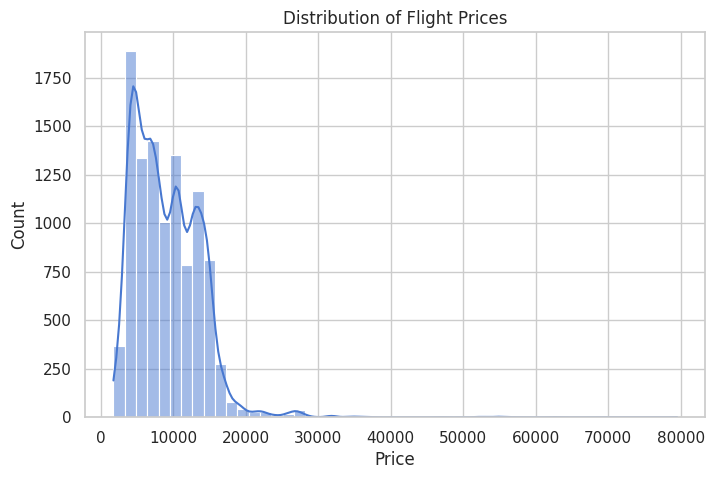

In [18]:
# Data visualization for insights and pattern recognition

plt.figure(figsize=(8,5))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title('Distribution of Flight Prices')
plt.show()

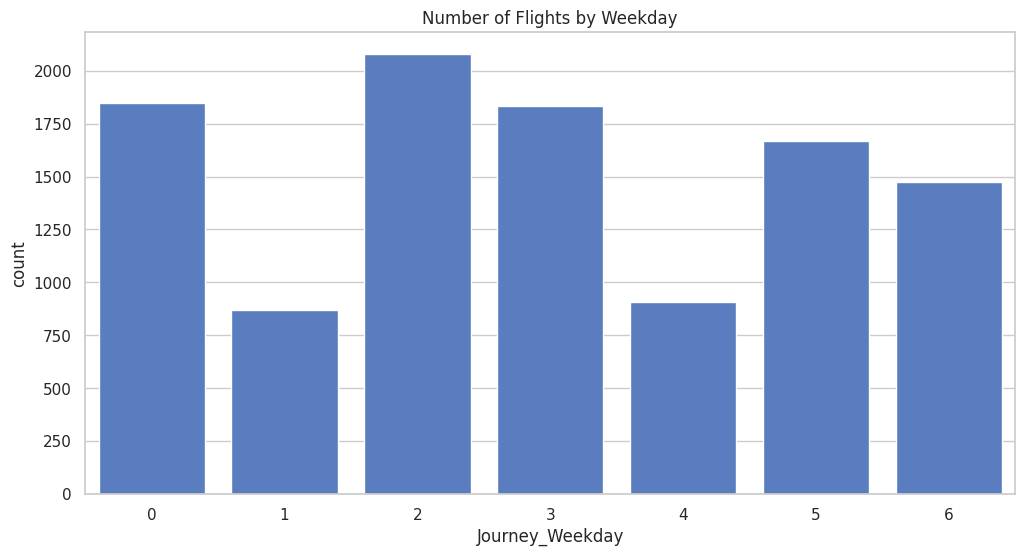

In [19]:
# Data visualization for insights and pattern recognition

plt.figure(figsize=(12,6))
sns.countplot(x='Journey_Weekday', data=df)
plt.title('Number of Flights by Weekday')
plt.show()

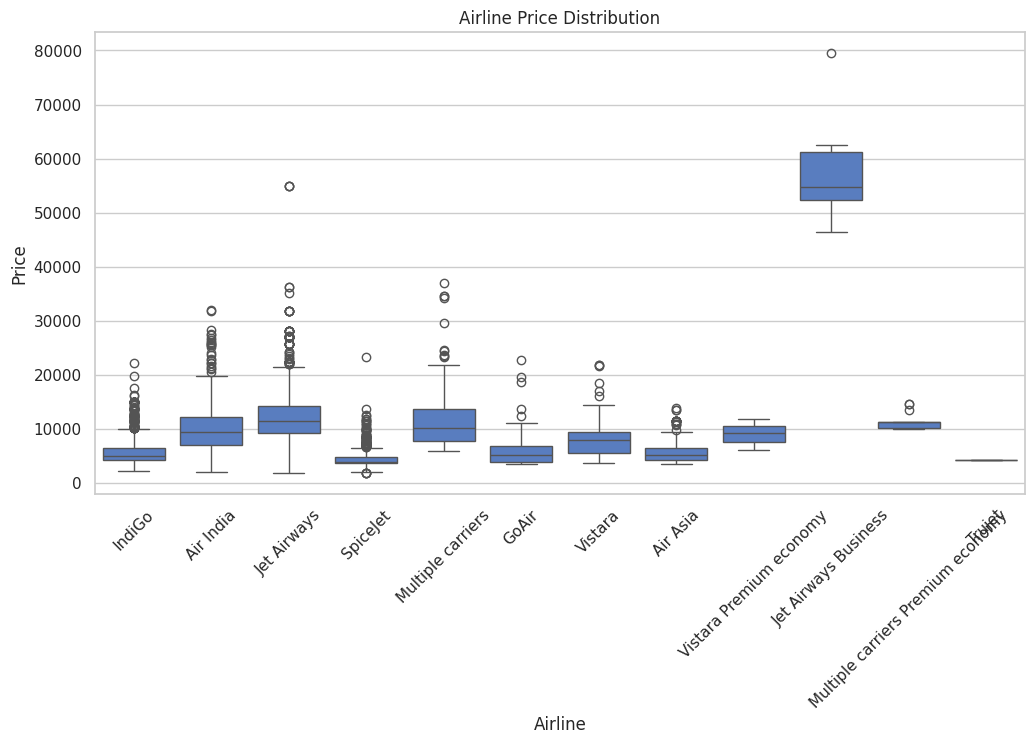

In [20]:
# Data visualization for insights and pattern recognition

plt.figure(figsize=(12,6))
sns.boxplot(x='Airline', y='Price', data=df)
plt.title('Airline Price Distribution')
plt.xticks(rotation=45)
plt.show()

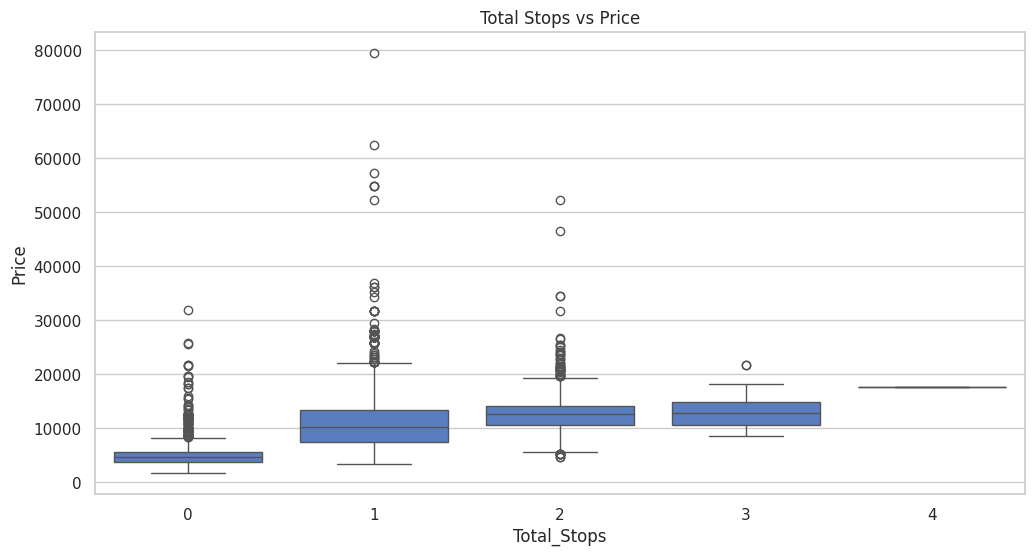

In [21]:
# Data visualization for insights and pattern recognition

plt.figure(figsize=(12,6))
sns.boxplot(x='Total_Stops', y='Price', data=df)
plt.title('Total Stops vs Price')
plt.show()

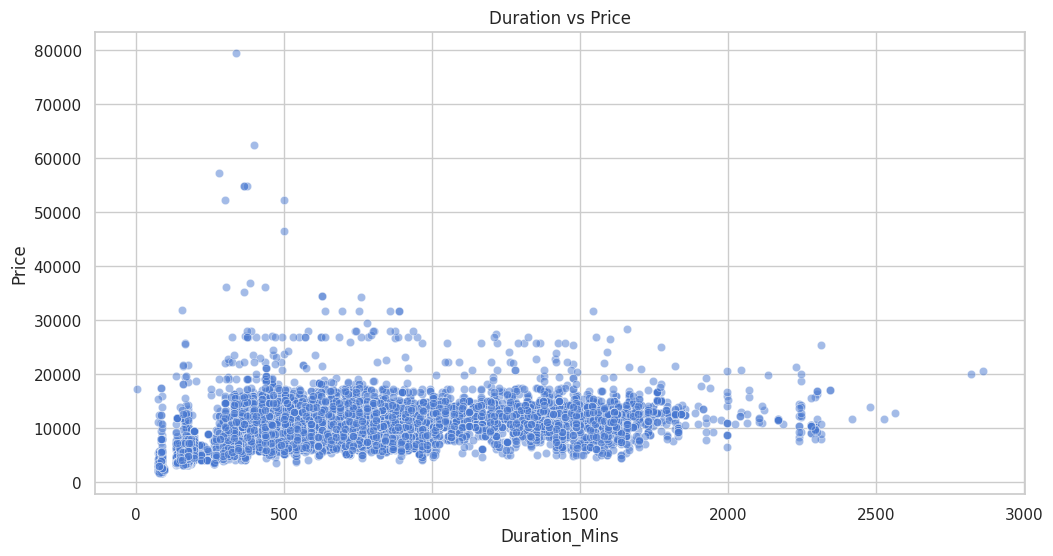

In [22]:
# Data visualization for insights and pattern recognition

plt.figure(figsize=(12,6))
sns.scatterplot(x='Duration_Mins', y='Price', data=df, alpha=0.5)
plt.title('Duration vs Price')
plt.show()

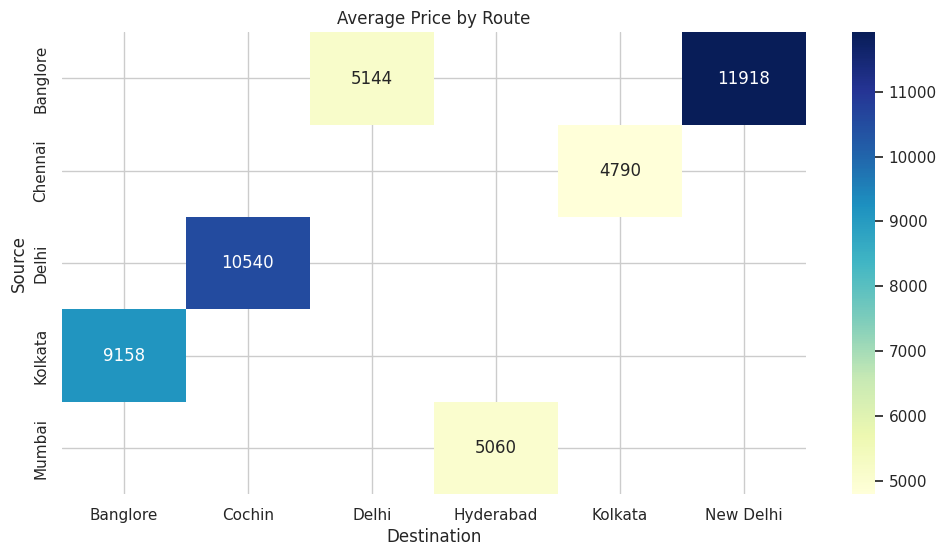

In [23]:
avg_price = df.groupby(['Source','Destination'])['Price'].mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(avg_price, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Average Price by Route')
plt.show()

## Feature Encoding & Train/Test Split

In [24]:
encoded_data = pd.get_dummies(df, columns=["Airline","Source","Destination","Additional_Info"], drop_first=True)

X = encoded_data.drop("Price", axis=1)
y = encoded_data["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8545, 38), (2137, 38), (8545,), (2137,))

## Baseline Models

In [25]:
# Training a model (ensure train-test split and validation are handled)
# Making predictions using the trained model
results = {}

def evaluate(model, name):
    y_pred = model.predict(X_test)
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
evaluate(lr, "Linear Regression")

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1).fit(X_train, y_train)
evaluate(rf, "Random Forest")

# XGBoost
xgb = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1).fit(X_train, y_train)
evaluate(xgb, "XGBoost")

# LightGBM
lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1).fit(X_train, y_train)
evaluate(lgbm, "LightGBM")

pd.DataFrame(results).T.sort_values(by="R2", ascending=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 8545, number of used features: 29
[LightGBM] [Info] Start training from score 9078.336688


,RMSE,MAE,R2
XGBoost,1332.574763,643.796692,0.917644
Random Forest,1419.208526,605.319954,0.906588
LightGBM,1474.199022,739.985662,0.899209
Linear Regression,2575.842462,1765.017085,0.692285


## Hyperparameter Tuning
We perform hyperparameter tuning for **XGBoost** and **LightGBM** using RandomizedSearchCV.

In [26]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Results -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
    return rmse, mae, r2

# XGBoost parameter grid
xgb_param_grid = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8, 10],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1),
    param_distributions=xgb_param_grid,
    n_iter=20, scoring="neg_root_mean_squared_error", cv=3, verbose=1, random_state=42, n_jobs=-1
)
xgb_random.fit(X_train, y_train)
print('-'*100)
print("Best Params (XGB):", xgb_random.best_params_)
evaluate_model(xgb_random.best_estimator_, X_test, y_test, "Tuned XGBoost")

# LightGBM parameter grid
lgbm_param_grid = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 6, 8],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

lgbm_random = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42, n_jobs=-1),
    param_distributions=lgbm_param_grid,
    n_iter=20, scoring="neg_root_mean_squared_error", cv=3, verbose=1, random_state=42, n_jobs=-1
)
lgbm_random.fit(X_train, y_train)
print('-'*100)
print("Best Params (LGBM):", lgbm_random.best_params_)
evaluate_model(lgbm_random.best_estimator_, X_test, y_test, "Tuned LightGBM")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------------------------------------------------------------------------------------------------
Best Params (XGB): {'subsample': 0.8, 'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Tuned XGBoost Results -> RMSE: 1313.26, MAE: 660.38, R²: 0.9200
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 8545, number of used features: 29
[LightGBM] [Info] Start training from score 9078.336688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

(np.float64(1507.0237511468783), 731.6084198334065, 0.894670501162922)

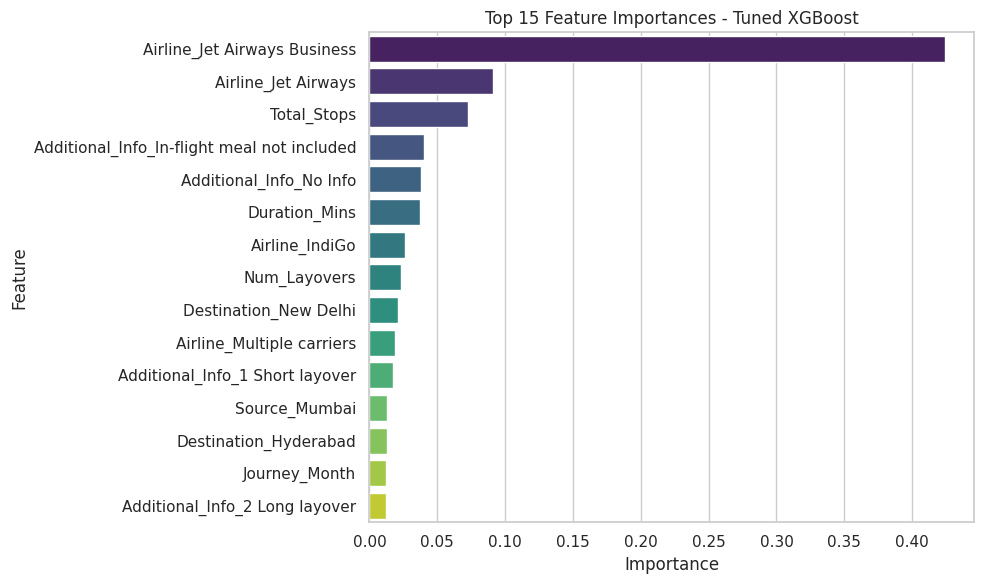

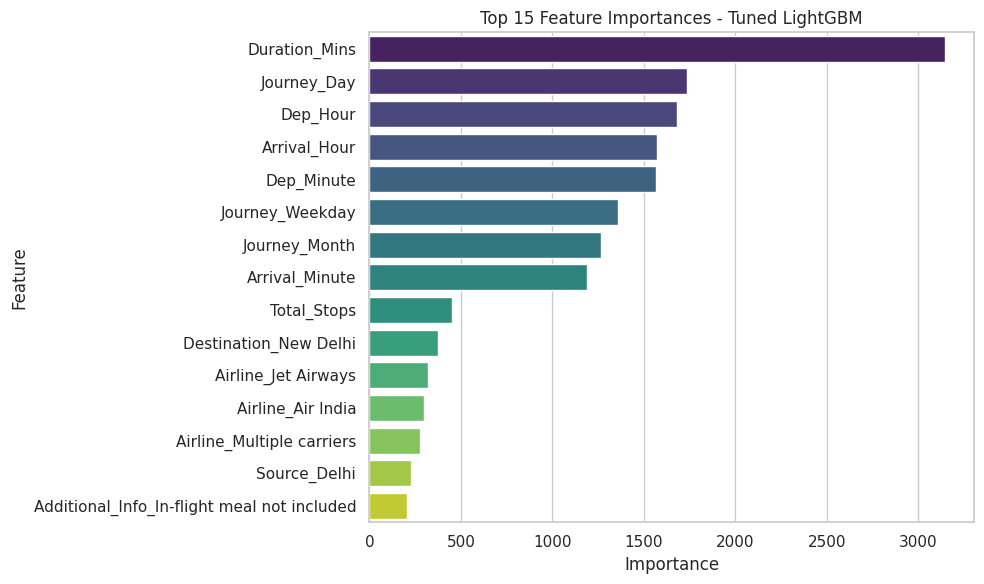

,Feature,Importance
8,Duration_Mins,3146
1,Journey_Day,1735
4,Dep_Hour,1682
6,Arrival_Hour,1573
5,Dep_Minute,1567
3,Journey_Weekday,1360
2,Journey_Month,1263
7,Arrival_Minute,1190
0,Total_Stops,450
29,Destination_New Delhi,374


In [27]:
def plot_feature_importance(model, X, model_name="Model"):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        features = X.columns
        importance_df = pd.DataFrame({
            "Feature": features,
            "Importance": importance
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(10,6))
        sns.barplot(x="Importance", y="Feature", data=importance_df.head(15), palette="viridis")
        plt.title(f"Top 15 Feature Importances - {model_name}")
        plt.tight_layout()
        plt.show()
        return importance_df
    else:
        print(f"{model_name} does not support feature_importances_")
        return None

# Plot for tuned models
plot_feature_importance(xgb_random.best_estimator_, X_train, "Tuned XGBoost")
plot_feature_importance(lgbm_random.best_estimator_, X_train, "Tuned LightGBM")

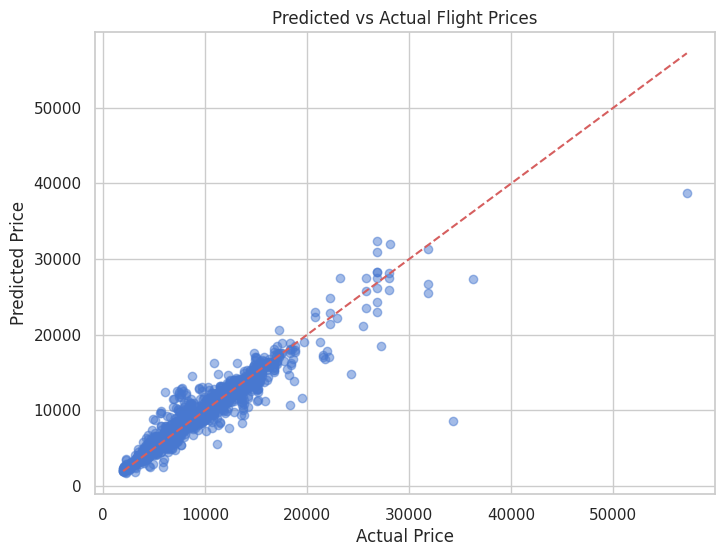

In [28]:
# Data visualization for insights and pattern recognition
plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_random.best_estimator_.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Flight Prices")
plt.show()

In [29]:
# Compare RMSE between tuned models
rmse_xgb, _, _ = evaluate_model(xgb_random.best_estimator_, X_test, y_test, "Final XGBoost")
rmse_lgbm, _, _ = evaluate_model(lgbm_random.best_estimator_, X_test, y_test, "Final LightGBM")

best_model = xgb_random.best_estimator_ if rmse_xgb < rmse_lgbm else lgbm_random.best_estimator_
print("Selected Best Model:", "XGBoost" if rmse_xgb < rmse_lgbm else "LightGBM")

# Save model
joblib.dump(best_model, "best_flight_price_model.pkl")

# Save predictions
best_predictions = best_model.predict(X_test)
submission = pd.DataFrame({
    "Actual_Price": y_test.values,
    "Predicted_Price": best_predictions
})
submission.to_csv("flight_price_predictions.csv", index=False)

print("Model saved as best_flight_price_model.pkl")
print("Predictions saved as flight_price_predictions.csv")

submission.head()

Final XGBoost Results -> RMSE: 1313.26, MAE: 660.38, R²: 0.9200
Final LightGBM Results -> RMSE: 1507.02, MAE: 731.61, R²: 0.8947
Selected Best Model: XGBoost
Model saved as best_flight_price_model.pkl
Predictions saved as flight_price_predictions.csv


,Actual_Price,Predicted_Price
0,16655,16349.894531
1,4959,5363.909668
2,9187,8377.580078
3,3858,3821.927734
4,12898,12503.046875
